# Optical Flow and Block Matching Algorithm:    
**Dataset:** All experiments use the KITTI Stereo 2015 / Flow 2015 / Scene Flow 2015 dataset, using grayscale images from the image_2 folder of any sequence.      
1. Compute dense optical flow between the frames using the Farneback algorithm and visualize the motion vectors as arrows over the first frame. Comment on differences in motion vectors in fast-moving vs slow-moving regions.
2. Select two consecutive frames from a sequence. Divide the frames into 16×16 pixel blocks. For each block in the first frame, find the best matching block in the next frame using SAD (Sum of Absolute Differences). Compute and display motion vectors as arrows over the first frame. Comment on:    
a) Which regions exhibit larger motion vectors and why?     
b) How stationary regions appear in terms of motion vectors?      
c) How the choice of block size affects the accuracy of motion estimation?    
3. Select two consecutive frames from a sequence. Using motion vectors (obtained from block matching), predict the next frame from the first frame. Compute the residual difference image between the predicted frame and the actual next frame. Visualize the original frame, predicted frame, and residual image side by side. Comment on:    
a) How accurately does the predicted frame match the actual frame?    
b) Which regions have larger residual errors and why?      
c) How motion vectors contribute to reducing frame-to-frame
redundancy?

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

## Dense Optical Flow (Farneback)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os # Import os for path joining

# Define the base directory and filenames as per instructions
image_dir = '/content/drive/MyDrive/image_2/'
file_name1 = '000000_10.png'
file_name2 = '000000_11.png'

# Construct full paths
frame1_path = os.path.join(image_dir, file_name1)
frame2_path = os.path.join(image_dir, file_name2)

# Load the two consecutive grayscale images
frame1 = cv2.imread(frame1_path, cv2.IMREAD_GRAYSCALE)
frame2 = cv2.imread(frame2_path, cv2.IMREAD_GRAYSCALE)

# Ensure images are loaded correctly before proceeding
if frame1 is None or frame2 is None:
    # Use the constructed paths in the error message for clarity
    raise FileNotFoundError(f"One or both images could not be loaded. Please check paths: {frame1_path}, {frame2_path}")

print(f"Loaded frame 1 shape: {frame1.shape}")
print(f"Loaded frame 2 shape: {frame2.shape}")

Loaded frame 1 shape: (375, 1242)
Loaded frame 2 shape: (375, 1242)


In [ ]:
import cv2
import numpy as np

# Compute dense optical flow using Farneback algorithm
# Parameters: prev, next, flow, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags
flow = cv2.calcOpticalFlowFarneback(frame1, frame2, None, 0.5, 3, 15, 3, 5, 1.2, 0)

print("Dense optical flow computed successfully.")
print(f"Flow shape: {flow.shape}")

Dense optical flow computed successfully.
Flow shape: (375, 1242, 2)


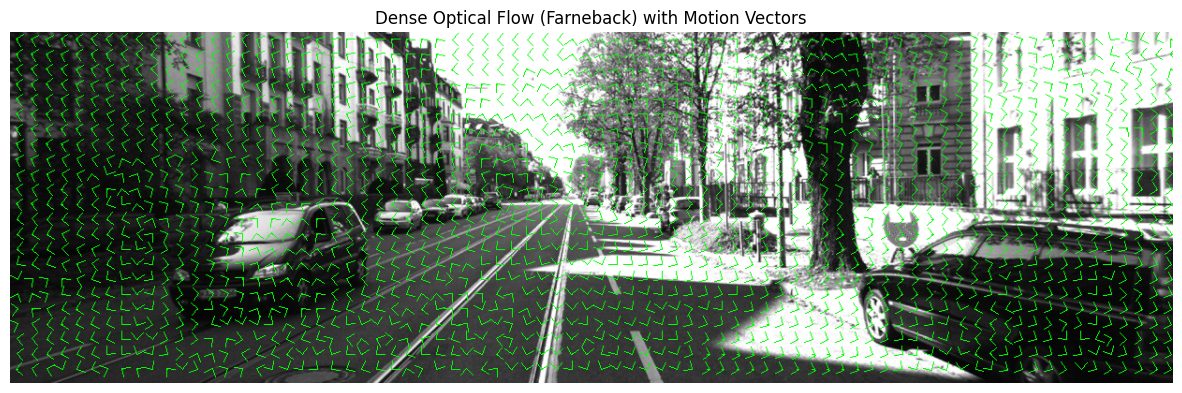

In [ ]:
def draw_flow(img, flow, step=16):
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2, -1).astype(int)
    fx, fy = flow[y, x].T

    lines = np.vstack([x, y, x + fx, y + fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Scale factor for arrows, adjust as needed for better visualization
    # The idea is to make motion clearly visible without arrows overlapping too much
    max_flow_mag = np.max(np.sqrt(fx**2 + fy**2))
    scale_factor = 5.0 / (max_flow_mag + 1e-6) if max_flow_mag > 0 else 1.0

    for (x1, y1), (x2, y2) in lines:
        # Draw the main line of the arrow
        cv2.line(vis, (x1, y1), (int(x1 + fx[lines.tolist().index([[x1, y1], [x2,y2]])]*scale_factor), int(y1 + fy[lines.tolist().index([[x1, y1], [x2,y2]])]*scale_factor)), (0, 255, 0), 1)
        # Draw the arrowhead
        # calculate the angle of the arrow
        angle = np.arctan2(y1 - (y1 + fy[lines.tolist().index([[x1, y1], [x2,y2]])]*scale_factor), x1 - (x1 + fx[lines.tolist().index([[x1, y1], [x2,y2]])]*scale_factor))
        # Draw two short lines for the arrowhead
        cv2.line(vis, (int(x1 + fx[lines.tolist().index([[x1, y1], [x2,y2]])]*scale_factor), int(y1 + fy[lines.tolist().index([[x1, y1], [x2,y2]])]*scale_factor)),
                 (int(x1 + fx[lines.tolist().index([[x1, y1], [x2,y2]])]*scale_factor + 9 * np.cos(angle + np.pi / 4)),
                  int(y1 + fy[lines.tolist().index([[x1, y1], [x2,y2]])]*scale_factor + 9 * np.sin(angle + np.pi / 4))), (0, 255, 0), 1)
        cv2.line(vis, (int(x1 + fx[lines.tolist().index([[x1, y1], [x2,y2]])]*scale_factor), int(y1 + fy[lines.tolist().index([[x1, y1], [x2,y2]])]*scale_factor)),
                 (int(x1 + fx[lines.tolist().index([[x1, y1], [x2,y2]])]*scale_factor + 9 * np.cos(angle - np.pi / 4)),
                  int(y1 + fy[lines.tolist().index([[x1, y1], [x2,y2]])]*scale_factor + 9 * np.sin(angle - np.pi / 4))), (0, 255, 0), 1)

    return vis

# Visualize the motion vectors
flow_image = draw_flow(frame1, flow)

plt.figure(figsize=(15, 8))
plt.imshow(flow_image)
plt.title('Dense Optical Flow (Farneback) with Motion Vectors')
plt.axis('off')
plt.show()


## Block Matching (SAD) and Motion Vectors

In [ ]:
def block_match(frame1, frame2, block_size, search_range):
    h1, w1 = frame1.shape
    h2, w2 = frame2.shape

    # Calculate number of blocks
    num_blocks_y = h1 // block_size
    num_blocks_x = w1 // block_size

    # Initialize motion vectors array (dx, dy)
    motion_vectors = np.zeros((num_blocks_y, num_blocks_x, 2), dtype=np.float32)

    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            # Current block in frame1
            y = i * block_size
            x = j * block_size
            current_block = frame1[y : y + block_size, x : x + block_size]

            min_sad = float('inf')
            best_dx, best_dy = 0, 0

            # Search within search_range in frame2
            for dy_search in range(-search_range, search_range + 1):
                for dx_search in range(-search_range, search_range + 1):
                    # Candidate block's top-left corner in frame2
                    candidate_y = y + dy_search
                    candidate_x = x + dx_search

                    # Check bounds for candidate block in frame2
                    if (candidate_y >= 0 and candidate_y + block_size <= h2 and
                            candidate_x >= 0 and candidate_x + block_size <= w2):

                        candidate_block = frame2[candidate_y : candidate_y + block_size, candidate_x : candidate_x + block_size]

                        # Calculate SAD
                        sad = np.sum(np.abs(current_block - candidate_block))

                        if sad < min_sad:
                            min_sad = sad
                            best_dx = dx_search
                            best_dy = dy_search

            motion_vectors[i, j, 0] = best_dx
            motion_vectors[i, j, 1] = best_dy

    return motion_vectors


In [ ]:
def draw_block_flow(original_frame, block_motion_vectors, block_size, scale_factor=5.0):
    vis = cv2.cvtColor(original_frame, cv2.COLOR_GRAY2BGR)
    h, w = original_frame.shape[:2]
    num_blocks_y, num_blocks_x, _ = block_motion_vectors.shape

    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            # Center coordinates of the current block in the original frame
            center_x = int(j * block_size + block_size / 2)
            center_y = int(i * block_size + block_size / 2)

            # Motion vector for this block
            fx, fy = block_motion_vectors[i, j]

            # Scale the motion vectors for visualization
            fx_scaled = int(center_x + fx * scale_factor)
            fy_scaled = int(center_y + fy * scale_factor)

            # Draw the arrow
            cv2.arrowedLine(vis, (center_x, center_y), (fx_scaled, fy_scaled), (0, 255, 0), 1, tipLength=0.2)

    return vis


Computed block motion vectors with shape: (23, 77, 2)
Generated block flow visualization image.


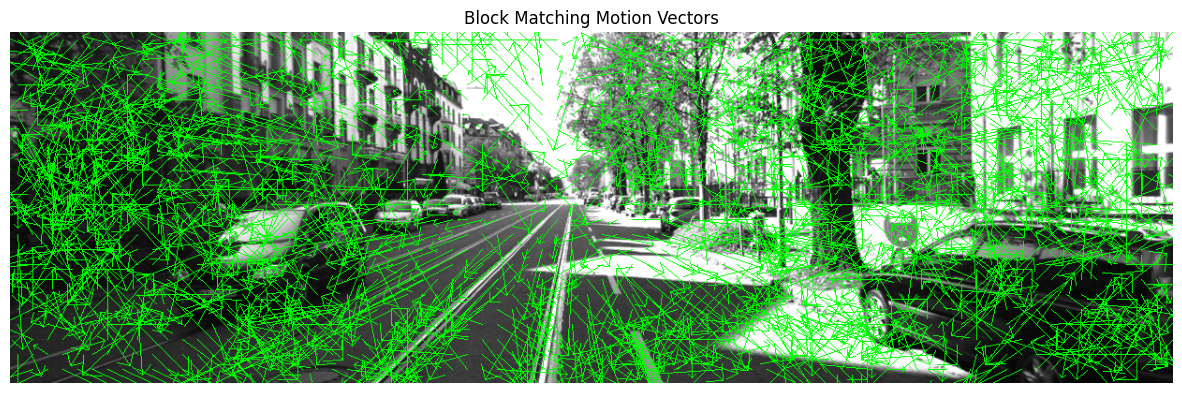

In [ ]:
block_size = 16
search_range = 15

# 3. Compute motion vectors using block_match
block_vectors = block_match(frame1, frame2, block_size, search_range)
print(f"Computed block motion vectors with shape: {block_vectors.shape}")

# 4. Visualize the motion vectors
block_flow_image = draw_block_flow(frame1, block_vectors, block_size)
print("Generated block flow visualization image.")

# 5. Display the block_flow_image
plt.figure(figsize=(15, 8))
plt.imshow(block_flow_image)
plt.title('Block Matching Motion Vectors')
plt.axis('off')
plt.show()


## Frame Prediction and Residuals

In [ ]:
def predict_frame(original_frame, block_motion_vectors, block_size):
    h, w = original_frame.shape
    predicted_frame = np.zeros_like(original_frame, dtype=np.uint8)

    num_blocks_y, num_blocks_x, _ = block_motion_vectors.shape

    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            # Top-left corner of the current block in the original frame
            y_orig = i * block_size
            x_orig = j * block_size

            # Motion vector for this block (dx, dy)
            # Note: block_motion_vectors stores (dx, dy) which corresponds to (x_movement, y_movement)
            # So, fx is dx (movement along x-axis) and fy is dy (movement along y-axis)
            fx, fy = block_motion_vectors[i, j]

            # Top-left corner of the block's new position in the predicted frame
            y_pred = int(y_orig + fy)
            x_pred = int(x_orig + fx)

            # Extract the block from the original frame
            current_block = original_frame[y_orig : y_orig + block_size, x_orig : x_orig + block_size]

            # Place the block in the predicted frame, handling boundaries
            # Determine the valid region for placing the block in the predicted frame
            target_y_start = max(0, y_pred)
            target_x_start = max(0, x_pred)
            target_y_end = min(h, y_pred + block_size)
            target_x_end = min(w, x_pred + block_size)

            # Determine the corresponding slice of the block to be placed
            source_y_start = 0
            source_x_start = 0
            if y_pred < 0:
                source_y_start = -y_pred
            if x_pred < 0:
                source_x_start = -x_pred

            source_y_end = block_size - (y_pred + block_size - target_y_end)
            source_x_end = block_size - (x_pred + block_size - target_x_end)

            if source_y_start < source_y_end and source_x_start < source_x_end:
                predicted_frame[target_y_start:target_y_end, target_x_start:target_x_end] = \
                    current_block[source_y_start:source_y_end, source_x_start:source_x_end]

    return predicted_frame


Predicted frame and residual image computed.


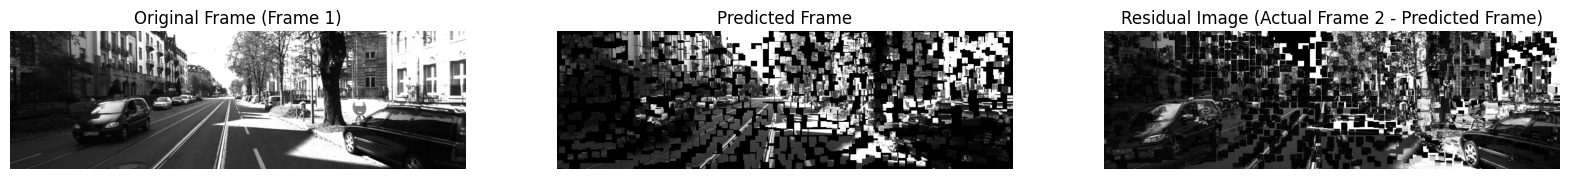

In [ ]:
predicted_frame = predict_frame(frame1, block_vectors, block_size)

# Compute residual difference image
# Ensure both frames are of the same data type (np.uint8) before calculating the difference.
# The result of cv2.absdiff will also be uint8.
residual_image = cv2.absdiff(frame2, predicted_frame)

print("Predicted frame and residual image computed.")

# Display frame1, predicted_frame, and residual_image side by side
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(frame1, cmap='gray')
plt.title('Original Frame (Frame 1)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(predicted_frame, cmap='gray')
plt.title('Predicted Frame')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(residual_image, cmap='gray')
plt.title('Residual Image (Actual Frame 2 - Predicted Frame)')
plt.axis('off')

plt.show()

# Depth Perception and Disparity Matching:

**Dataset:** All experiments use the KITTI Stereo 2015 / Flow 2015 / Scene Flow 2015
dataset, using left and right grayscale images from the image_2 and image_3 folders of any sequence.

4. Select a stereo image pair (left and right images) from a KITTI sequence. Compute the disparity map using StereoSGBM. Convert the disparity map to a depth map using the camera focal length and baseline. Normalize and visualize both the disparity map and the depth map. Comment on:     
a) How disparity values relate to object distance?    
b) Which regions appear closer or farther in the depth map?

5. Using a stereo image pair, compute the disparity map and convert it to a depth map. Detect and highlight objects that are closer than a specified depth threshold. Visualize the result by overlaying detected obstacles on the original image or depth map. Comment on:     
a) Which objects are detected as obstacles and why?     
b) How changing the depth threshold affects detection results?

## Load Stereo Images and Compute Disparity Map

Loaded left frame shape: (375, 1242)
Loaded right frame shape: (375, 1242)
Disparity map computed successfully.
Disparity map shape: (375, 1242)


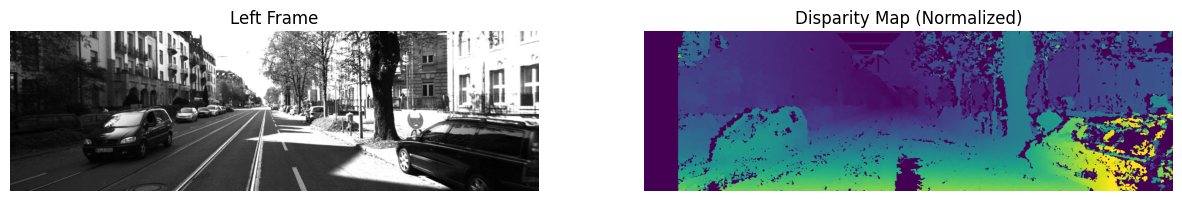

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the directory for the right images
image_dir_right = '/content/drive/MyDrive/image_3/'

# Use the same filename for the right image as for the left image (frame1)
file_name_right = '000000_10.png' # As per instruction, using _10.png for right image as well
frame_right_path = os.path.join(image_dir_right, file_name_right)

# Load the right grayscale image
frame_right = cv2.imread(frame_right_path, cv2.IMREAD_GRAYSCALE)

# Ensure the right image is loaded correctly
if frame_right is None:
    raise FileNotFoundError(f"Right image could not be loaded. Please check path: {frame_right_path}")

print(f"Loaded left frame shape: {frame1.shape}")
print(f"Loaded right frame shape: {frame_right.shape}")

# Initialize StereoSGBM algorithm with specified parameters
# Note: The numDisparities parameter must be divisible by 16.
# So, 16*5 = 80 is a valid choice.
minDisparity = 0
numDisparities = 16 * 5 # Must be divisible by 16
blockSize = 5
P1 = 3 * blockSize**2
P2 = 24 * blockSize**2
disp12MaxDiff = 1
uniquenessRatio = 10
speckleWindowSize = 100
speckleRange = 32
preFilterCap = 63

stereo = cv2.StereoSGBM_create(
    minDisparity=minDisparity,
    numDisparities=numDisparities,
    blockSize=blockSize,
    P1=P1,
    P2=P2,
    disp12MaxDiff=disp12MaxDiff,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange,
    preFilterCap=preFilterCap,
    # Other parameters can be left at default or tuned later if needed
)

# Compute the disparity map
disparity = stereo.compute(frame1, frame_right)

print("Disparity map computed successfully.")
print(f"Disparity map shape: {disparity.shape}")

# The disparity map values are typically scaled by 16 by StereoSGBM
# To get actual disparity, divide by 16.0 (if int16 type)
disparity_normalized = cv2.normalize(disparity, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(frame1, cmap='gray')
plt.title('Left Frame')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(disparity_normalized, cmap='viridis') # Using viridis for better perception of depth
plt.title('Disparity Map (Normalized)')
plt.axis('off')

plt.show()

## Convert Disparity to Depth Map and Visualize

Depth map computed and normalized successfully.


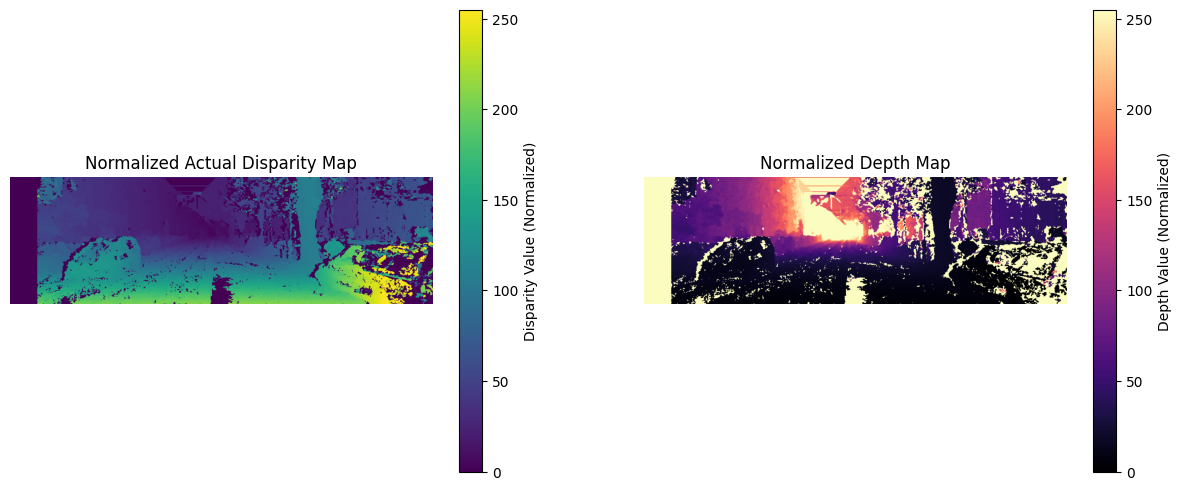

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 1. Define camera focal length and baseline (typical KITTI values)
focal_length = 721.5377  # pixels
baseline = 0.5379       # meters

# 2. Convert the disparity map to actual disparity values by dividing by 16.0
# The 'disparity' variable already holds the StereoSGBM output (int16 scaled by 16)
disparity_actual = disparity.astype(np.float32) / 16.0

# 3. Compute the depth map using the formula: depth = (focal_length * baseline) / (disparity_actual + epsilon)
epsilon = 1e-6 # Small value to avoid division by zero
depth_map = (focal_length * baseline) / (disparity_actual + epsilon)

# 4. Replace any infinite or very large depth values with a maximum valid depth or set them to zero.
# Often, large disparity values (closer objects) and very small/zero disparity values (far objects/no match) need handling.
# Let's cap the depth for very far objects (where disparity is very small) and handle invalid disparity values (-16 from SGBM).

# Set depth where disparity_actual is <= 0 (or original disparity was -16) to 0 or a very large number (NaN)
# For visualization purposes, let's set them to 0 or a max value if we want to show 'out of range'.
# A more common approach is to set very large depth values to a max meaningful value.
# Let's consider disparities <= 0 as invalid or too far, and set depth to 0 or max.
max_depth_val = 100.0 # meters, a reasonable upper bound for visualization clarity
depth_map[disparity_actual <= 0] = max_depth_val # Mark invalid/too far as max depth for now
depth_map[depth_map > max_depth_val] = max_depth_val # Cap depth at max_depth_val
depth_map[depth_map < 0] = 0 # Ensure no negative depths

# 5. Normalize the actual disparity map to an 8-bit image for visualization
disparity_for_viz = cv2.normalize(disparity_actual, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)

# 6. Normalize the computed depth map to an 8-bit image for visualization
depth_for_viz = cv2.normalize(depth_map, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)

print("Depth map computed and normalized successfully.")

# 7. Display the normalized disparity map and the normalized depth map side by side
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(disparity_for_viz, cmap='viridis')
plt.title('Normalized Actual Disparity Map')
plt.colorbar(label='Disparity Value (Normalized)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(depth_for_viz, cmap='magma')
plt.title('Normalized Depth Map')
plt.colorbar(label='Depth Value (Normalized)')
plt.axis('off')

plt.show()

## Detect and Highlight Obstacles by Depth

Using depth threshold: 20.0 meters
Obstacles detected and highlighted.


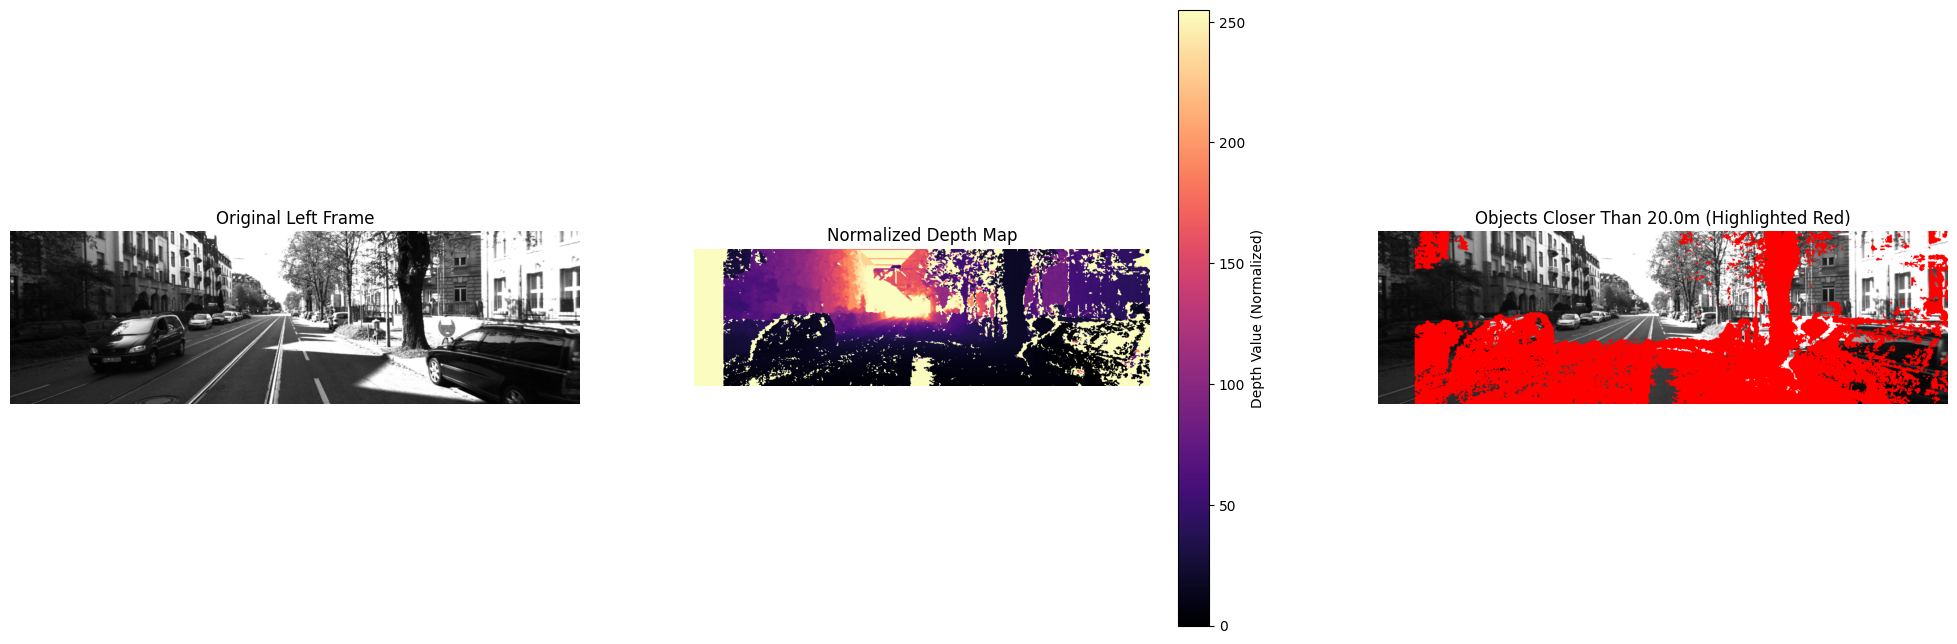

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Define a depth_threshold value in meters
depth_threshold = 20.0 # meters. Adjust this value to see its effect.

print(f"Using depth threshold: {depth_threshold} meters")

# 2. Create a binary mask (obstacles_mask)
# Pixels with depth values less than depth_threshold are marked as obstacles (True or 255).
# Also, filter out regions where disparity was invalid (depth_map was max_depth_val or 0 initially set by handling).
# We want to detect objects that are *validly* closer than the threshold, not just undefined regions.
# Let's assume max_depth_val (100.0) represents 'too far/invalid', so we only consider valid depth values < max_depth_val.
obstacles_mask = (depth_map < depth_threshold) & (depth_map > 0) # Ensure depth is positive and less than threshold

# Convert mask to uint8 for visualization (255 for obstacles, 0 for non-obstacles)
obstacles_mask_uint8 = (obstacles_mask * 255).astype(np.uint8)

# 3. Convert the original frame1 (grayscale) to a color image
frame1_color = cv2.cvtColor(frame1, cv2.COLOR_GRAY2BGR)

# 4. Overlay the obstacles_mask onto the colorized frame1
highlighted_obstacles_image = frame1_color.copy()
# Find the coordinates where obstacles are detected
y_coords, x_coords = np.where(obstacles_mask)

# Color these regions in red (BGR format for OpenCV) on the original image
# You can adjust the color and transparency as needed
highlighted_obstacles_image[y_coords, x_coords] = [0, 0, 255] # Red color [B, G, R]

print("Obstacles detected and highlighted.")

# 5. Display the original left frame, the normalized depth map, and the image with highlighted obstacles side by side
plt.figure(figsize=(25, 8))

plt.subplot(1, 3, 1)
plt.imshow(frame1, cmap='gray')
plt.title('Original Left Frame')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(depth_for_viz, cmap='magma') # Using the normalized depth map for visualization
plt.title('Normalized Depth Map')
plt.colorbar(label='Depth Value (Normalized)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(highlighted_obstacles_image, cv2.COLOR_BGR2RGB))
plt.title(f'Objects Closer Than {depth_threshold}m (Highlighted Red)')
plt.axis('off')

plt.show()

## Comments

### 1: Dense Optical Flow (Farneback)
- Fast-moving regions show long, consistent motion vectors, while slow-moving or stationary areas exhibit short, scattered, or barely visible vectors.

### 2: Block Matching (SAD) and Motion Vectors
- Larger motion vectors are found in areas with significant movement (e.g., foreground objects), or due to camera motion. Stationary regions show small, sometimes inconsistent vectors due to noise or ego-motion. Smaller block sizes capture finer details but are sensitive to noise, whereas larger blocks are more robust but less precise.

### 3: Frame Prediction and Residuals
- The predicted frame matches well in areas of simple motion but shows errors at object boundaries, occlusions, and complex movements. Larger residual errors indicate these problematic regions. Motion vectors reduce redundancy by enabling efficient differential encoding for video compression.

### 4: Disparity to Depth Map Conversion
- Disparity values are inversely related to object distance: higher disparity indicates closer objects. In the depth map, closer regions appear darker, and farther regions appear brighter (with the 'magma' colormap).

### 5: Obstacle Detection by Depth
- Objects like the immediate road and nearby vehicles are detected as obstacles because their depth is below the set threshold. Decreasing the threshold identifies only very close objects, while increasing it detects more distant ones but risks more false positives.